<a href="https://colab.research.google.com/github/erogluegemen/Recommendation-System-with-GPU/blob/main/Content_based_Recommendation_with_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Content-based Recommendation with GPU

**Important Note**

[RAPIDS CUML Documentation](https://docs.rapids.ai/api/cuml/stable/api/)

> **_NOTE:_**  The ‘jaccard’ distance metric is only supported for **sparse** inputs.

## NVIDIA GPU RAPIDS CONFIG

In [1]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

!bash rapidsai-csp-utils/colab/install.sh

import sys
sys.path.append('/usr/local/lib/python3.10/site-packages/')

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
We will now install RAPIDS via pip!  Please stand by, should be quick...
***********************************************************************

bash: rapidsai-csp-utils/colab/install.sh: No such file or directory


## LIBRARIES

In [2]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import cudf
import cupy as cp

import scipy.sparse
import cupyx.scipy.sparse as cupy_sparse
from cuml.neighbors import NearestNeighbors

## SETUP

In [3]:
K = 30
PATH = "/content/drive/MyDrive/Recommendation_Systems/datasets/movies.csv"
movies_cpu = pd.read_csv(filepath_or_buffer=PATH, sep=",")

# Encode
genres_cpu = movies_cpu['genres'].str.get_dummies(sep='|')
genres_cpu.index = movies_cpu['movieId']

print(f"Genre matrix shape: {genres_cpu.shape}")
display(genres_cpu.head(3))

Genre matrix shape: (9742, 20)


,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


## DATA TRANSFORMATION

In [4]:
print(f"Original dense CPU shape: {genres_cpu.shape}")

print("\nConverting CPU pandas -> CPU sparse")
genres_sparse_cpu = scipy.sparse.csr_matrix(genres_cpu.values, dtype='bool')

print("\nTransferring CPU sparse -> GPU sparse")
start_transfer = time.time()

G_gpu_sparse = cupy_sparse.csr_matrix(genres_sparse_cpu)

end_transfer = time.time()
print(f"Transfer time: {end_transfer - start_transfer:.4f} seconds")

print(f"\nType of G_gpu_sparse: {type(G_gpu_sparse)}")
print(f"Shape of G_gpu_sparse: {G_gpu_sparse.shape}")
print(f"Dtype of G_gpu_sparse: {G_gpu_sparse.dtype}")

Original dense CPU shape: (9742, 20)

Converting CPU pandas -> CPU sparse

Transferring CPU sparse -> GPU sparse
Transfer time: 0.1758 seconds

Type of G_gpu_sparse: <class 'cupyx.scipy.sparse._csr.csr_matrix'>
Shape of G_gpu_sparse: (9742, 20)
Dtype of G_gpu_sparse: bool


## BUILD KNN

In [5]:
print(f"Starting GPU KNN build for K={K}")

knn_model = NearestNeighbors(n_neighbors=K+1, metric='jaccard', algorithm='brute')

start_fit = time.time()
print(f"\nFitting model with sparse input...")
knn_model.fit(G_gpu_sparse)

end_fit = time.time()
print(f"\nGPU fit time: {end_fit - start_fit:.4f} seconds")

start_query = time.time()
distances, indices = knn_model.kneighbors(G_gpu_sparse)
end_query = time.time()
print(f"GPU query time: {end_query - start_query:.4f} seconds")

print("\nGPU KNN Complete")
print("Distances shape:", distances.shape)
print("Indices shape:", indices.shape)

Starting GPU KNN build for K=30

Fitting model with sparse input...

GPU fit time: 0.1531 seconds
GPU query time: 0.2702 seconds

GPU KNN Complete
Distances shape: (9742, 31)
Indices shape: (9742, 31)


## TEST MODEL

In [6]:
indices_cpu = indices.get()
distances_cpu = distances.get()

index_to_movieid_map = dict(enumerate(genres_cpu.index))
title_map = movies_cpu.set_index('movieId')['title'].to_dict()

knn_map_with_names = {}
for row_index, neighbor_indices in enumerate(indices_cpu):
    source_movie_id = index_to_movieid_map[row_index]
    source_movie_title = title_map.get(source_movie_id, f"ID:{source_movie_id}")
    neighbor_movie_ids = [index_to_movieid_map[n] for n in neighbor_indices[1:]]
    neighbor_scores = [1.0 - d for d in distances_cpu[row_index][1:]]
    neighbor_titles = [title_map.get(mid, f"ID:{mid}") for mid in neighbor_movie_ids]
    knn_map_with_names[source_movie_title] = list(zip(neighbor_scores, neighbor_titles))

print("Testing results")
toy_story_key = title_map[1]
print(f"Top 5 neighbors for {toy_story_key}:")
for i in range(6):
  print(knn_map_with_names[toy_story_key][i])

Testing results
Top 5 neighbors for Toy Story (1995):
(np.float32(1.0), 'Turbo (2013)')
(np.float32(1.0), 'Asterix and the Vikings (Astérix et les Vikings) (2006)')
(np.float32(1.0), 'Shrek the Third (2007)')
(np.float32(1.0), 'Moana (2016)')
(np.float32(1.0), 'The Good Dinosaur (2015)')
(np.float32(1.0), 'Wild, The (2006)')


## VISUALIZATION

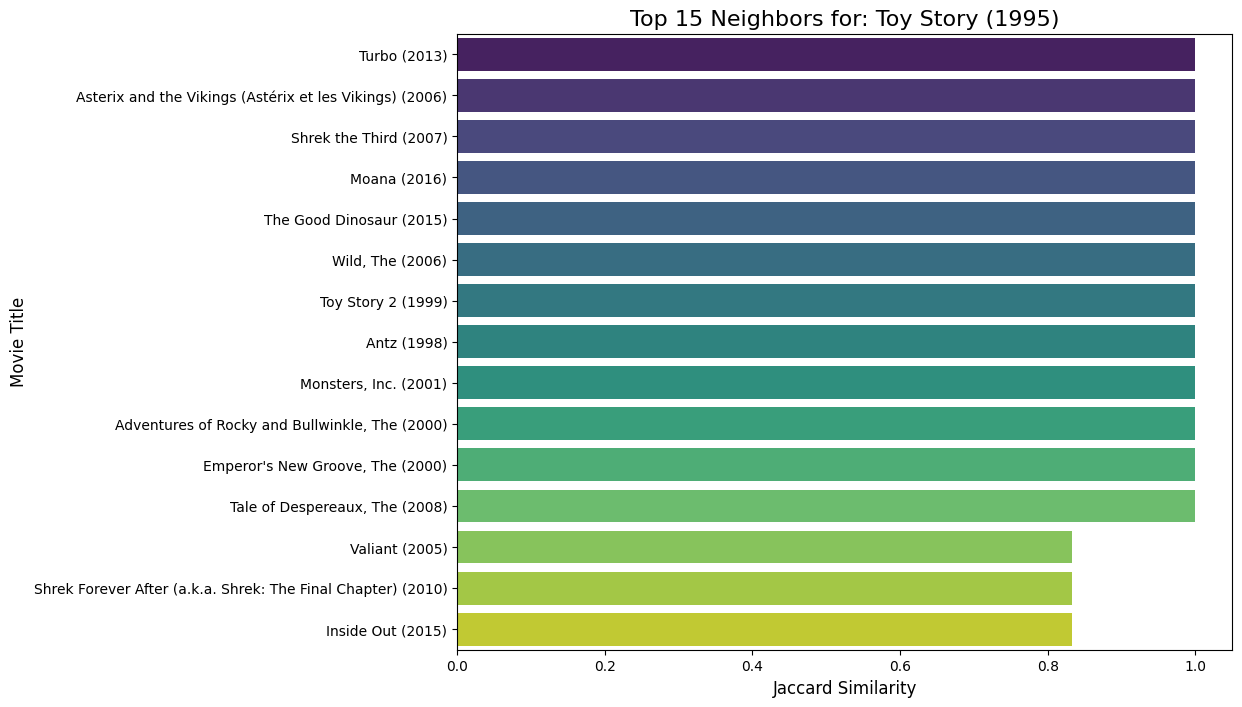

In [7]:
movie_title = 'Toy Story (1995)'

data = knn_map_with_names.get(movie_title, [])

neighbors_df = pd.DataFrame(data, columns=['similarity', 'title']).head(15)

plt.figure(figsize=(10, 8))
sns.barplot(
  x='similarity',
  y='title',
  data=neighbors_df,
  palette='viridis',
  hue='title',
  legend=False,
)

plt.title(f"Top 15 Neighbors for: {movie_title}", fontsize=16)
plt.xlabel("Jaccard Similarity", fontsize=12)
plt.ylabel("Movie Title", fontsize=12)
plt.show()